# Working with USGS field measured discharge and stage data

In this exercise we will pull in measured discharge and stage data from the gage [03171000 NEW RIVER AT RADFORD, VA](https://waterdata.usgs.gov/nwis/uv?site_no=03171000). The goals is to look at the data, use regression to find a stage discharge relationship and then to test the predictive ability of the regression you develop agains USGS reported data.

## Load in the needed packages

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

# %matplotlib inline
import matplotlib.pyplot as plt
%matplotlib widget
%config InlineBackend.figure_format='retina' # hig-res plots for a Retina display 

## Load, condition, and plot the data

Let's load in the csv file we created into a Pandas dataframe that we will call ```Qp``` and display the dataframe

In [2]:
datafile = 'NewRiver_measured_Q_stage.csv'
meas = pd.read_csv(datafile)
display(meas)

,agency_cd,site_no,measurement_nu,measurement_dt,tz_cd,q_meas_used_fg,party_nm,site_visit_coll_agency_cd,gage_height_va,discharge_va,measured_rating_diff,gage_va_change,gage_va_time,control_type_cd,discharge_cd
0,USGS,3171000,1,1939-07-12,NaN,Yes,ARG/PNS,USGS,2.34,2420.0,Unspecified,NaN,NaN,NaN,NONE
1,USGS,3171000,2,1939-07-12,NaN,Yes,ARG/PNS,USGS,2.34,2410.0,Unspecified,NaN,NaN,NaN,NONE
2,USGS,3171000,3,1939-10-23,NaN,Yes,ODM/TWE,USGS,1.84,1090.0,Unspecified,NaN,NaN,NaN,NONE
3,USGS,3171000,4,1940-03-05,NaN,Yes,ARG/PNS,USGS,2.95,4530.0,Good,NaN,NaN,NaN,NONE
4,USGS,3171000,5,1940-03-05,NaN,Yes,ARG/PNS,USGS,4.37,10800.0,Unspecified,NaN,NaN,NaN,NONE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,USGS,3171000,510,2021-09-20 11:19:00,EDT,Yes,KTG/SHI,USGS,2.13,1200.0,Good,0.00,0.50,Clear,NONE
509,USGS,3171000,511,2021-11-18 12:00:48,EST,Yes,SHI/MRH/KTG,USGS,2.08,1430.0,Fair,-0.03,0.35,Clear,NONE
510,USGS,3171000,512,2022-02-16 11:10:41,EST,Yes,AML/KTG,USGS,2.98,4600.0,Good,0.00,0.25,Clear,NONE
511,USGS,3171000,513,2022-03-30 13:42:13,EDT,Yes,KTG,USGS,2.53,2970.0,Fair,NaN,NaN,Clear,NONE


Let's look at the data types

In [3]:
meas.dtypes

agency_cd                     object
site_no                        int64
measurement_nu                 int64
measurement_dt                object
tz_cd                         object
q_meas_used_fg                object
party_nm                      object
site_visit_coll_agency_cd     object
gage_height_va               float64
discharge_va                 float64
measured_rating_diff          object
gage_va_change               float64
gage_va_time                 float64
control_type_cd               object
discharge_cd                  object
dtype: object

In this exercise we really only care about the stage and discharge data. If these data types are already floats, then we can save each in a numpy array to make everything a little easier to work with. However, before we do this, let's go through and check for missing values (important for the curve fitting we'll do later on)

In [4]:
meas['gage_height_va'].isnull().sum()

1

In [5]:
meas['discharge_va'].isnull().sum()

1

It looks like we have one or more missing values in the stage and/or discharge data. Let's drop the rows with ```nan's``` (or grab the data from the frame without nans). We'll then check to make sure our new data frame has the nan value removed from the two columns we are interested in.

In [6]:
meas=meas[meas['gage_height_va'].notna()]
print('# of nan in the stage data =', meas['gage_height_va'].isnull().sum())
print('# of nan in the stage data =', meas['discharge_va'].isnull().sum())

# of nan in the stage data = 0
# of nan in the stage data = 0


We don't need most of the columns. Therefore, let's drop everything except stage and discharge and then sort the dataframe by discharge.

In [7]:
meas=meas.filter(['gage_height_va','discharge_va'])
meas=meas.sort_values('discharge_va')
meas=meas.reset_index(drop=True)
meas

,gage_height_va,discharge_va
0,1.19,233.0
1,1.21,248.0
2,1.28,281.0
3,1.24,293.0
4,1.32,329.0
...,...,...
507,15.44,54600.0
508,15.25,56700.0
509,18.83,72300.0
510,18.81,75200.0


No store stage and discharge in arrays for easy access

In [8]:
h = np.array(meas.gage_height_va)
Q = np.array(meas.discharge_va)

let's look at the data to make sure we grabbed the right columns.

In [9]:
print('the first 10 elements in stage,', h[0:10])
print('the first 10 elements in Q,', Q[0:10])

print('total length of the stage array =', len(h))
print('total length of the Q array =', len(Q)) 

the first 10 elements in stage, [1.19 1.21 1.28 1.24 1.32 1.32 1.37 1.4  1.45 1.49]
the first 10 elements in Q, [233. 248. 281. 293. 329. 338. 390. 439. 499. 517.]
total length of the stage array = 512
total length of the Q array = 512


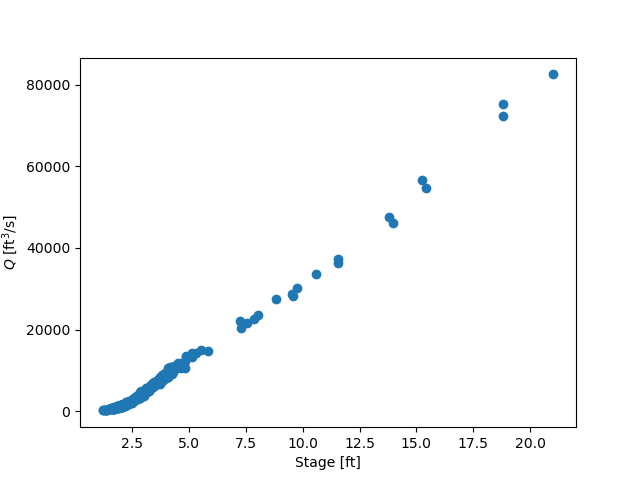

In [10]:
fig, ax1 = plt.subplots()
ax1.plot(h, Q,'o',alpha=1)
ax1.set_ylabel('$Q~\mathrm{[ft^3/s]}$')
ax1.set_xlabel('Stage [ft]');

Let's also plot it in log-log space to better see what is going on at lower stage and discharge values.

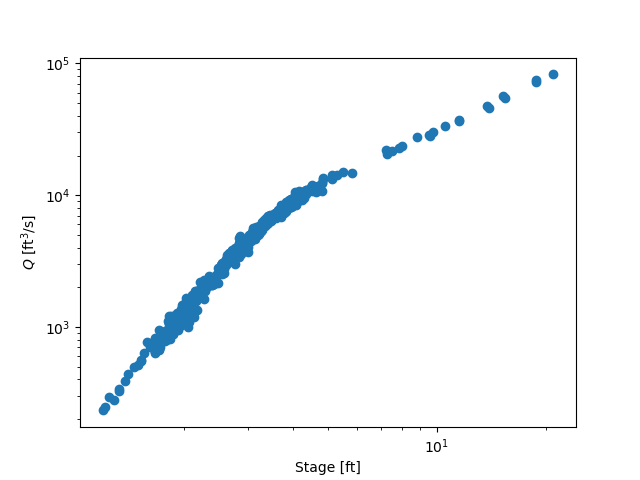

In [11]:
fig, ax1 = plt.subplots()
ax1.plot(h, Q,'o',alpha=1)
ax1.set_ylabel('$Q~\mathrm{[ft^3/s]}$')
ax1.set_xlabel('Stage [ft]')
ax1.set_xscale('log')
ax1.set_yscale('log');

What do you notice about the stage-discharge relationship plotted above?

## Regression to find $Q=Q(h)$

Let's refere to the stage as $h$ and the discharge as $Q$. What we want is a mathematical function that will give us discharge, $Q$, in the river if we have a measured stage, $h$. To obtain such a relation, let's try fitting different function to the $h$ and $Q$ data that the USGS has measuremed in the field at the Radford station on the New River.

To perform the curve fitting, we will need to load the ```curve_fit``` package from ```scipy```

In [12]:
from scipy.optimize import curve_fit

Try a simple power law fit with

$$ Q = \gamma + \alpha h^\beta $$

where $\gamma$, $\alpha$, and $\beta$ are the fit coefficients. First what we need to do is define a function of the form listed above that can be used in the fitting.

In [13]:
def powerlaw(x, a, b, c0):
    return c0 + a*x**b

Also define a pure power law with no off-set coefficient, i.e., $ Q = \alpha h^\beta $

In [14]:
def powerlawpure(x, a, b):
    return a*x**b

Now perform the the more general fit to find $\gamma$, $\alpha$, and $\beta$. The fit parameters are stored in the array ```popt```

In [15]:
popt, pcov = curve_fit(powerlaw, h, Q)
print('The fit coef are:')
print(popt)
print()
print(pcov)

The fit coef are:
[ 2.64873860e+03  1.14338268e+00 -4.35875300e+03]

[[ 2.91545699e+03 -3.76399057e-01 -6.06238513e+03]
 [-3.76399057e-01  4.97390371e-05  7.66703438e-01]
 [-6.06238513e+03  7.66703438e-01  1.35063357e+04]]


Now let's plot the fit against the data to visualize how it performed. To do this we'll generate an array of stage values ```hcalc``` that we'll feed to ```powerlaw(x, a, b, c0)``` along with the fit coefficients ```popt``` to generate the model line for the plot.

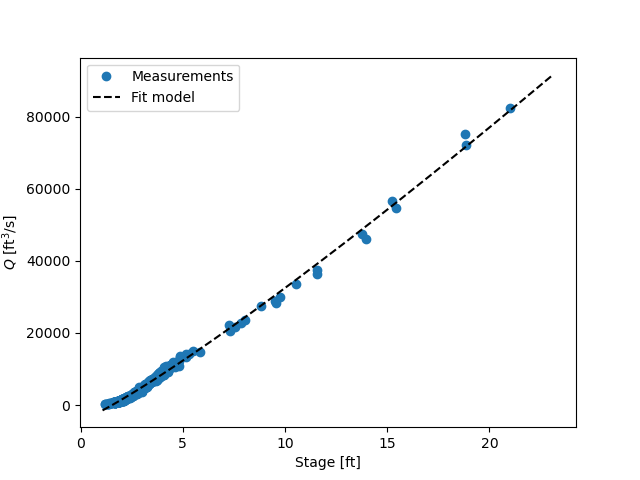

In [16]:
hcalc = np.linspace(min(h)-0.1*min(h),max(h)+0.1*max(h),200)

fig, ax = plt.subplots()
ax.plot(h, Q,'o',alpha=1, label='Measurements')
ax.plot(hcalc, powerlaw(hcalc,*popt),'--k',alpha=1, label='Fit model')
ax.set_ylabel('$Q~\mathrm{[ft^3/s]}$')
ax.set_xlabel('Stage [ft]')
ax.legend();

Plot in log-log space

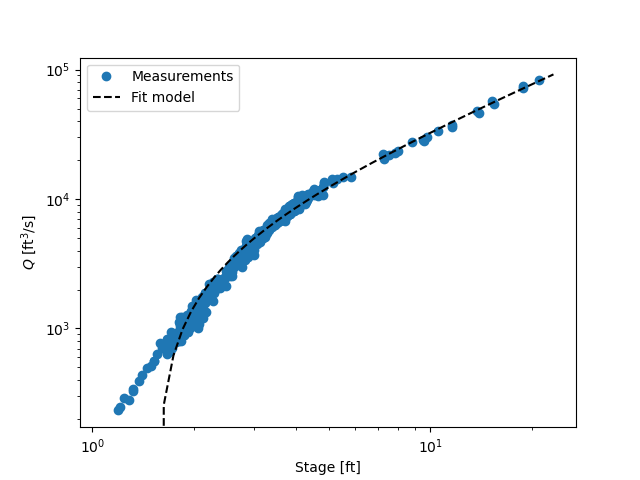

In [17]:
fig, ax = plt.subplots()
ax.plot(h, Q,'o',alpha=1, label='Measurements')
ax.plot(hcalc, powerlaw(hcalc,*popt),'--k',alpha=1, label='Fit model')
ax.set_ylabel('$Q~\mathrm{[ft^3/s]}$')
ax.set_xlabel('Stage [ft]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend();

let's try the pure power law with no intercept

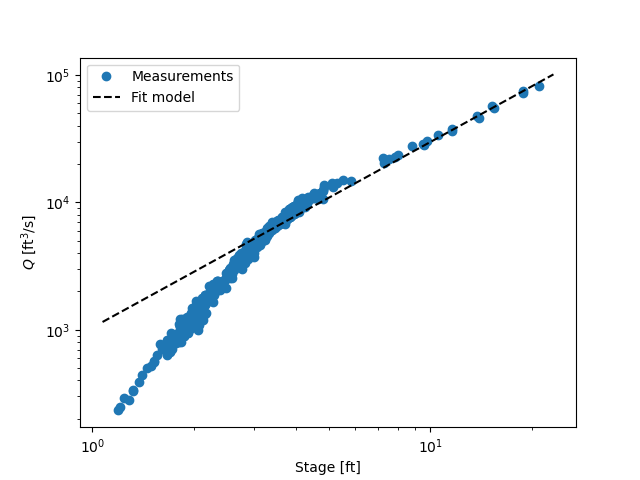

In [18]:
popt, pcov = curve_fit(powerlawpure, h, Q)

fig, ax = plt.subplots()
ax.plot(h, Q,'o',alpha=1, label='Measurements')
ax.plot(hcalc, powerlawpure(hcalc,*popt),'--k',alpha=1, label='Fit model')
ax.set_ylabel('$Q~\mathrm{[ft^3/s]}$')
ax.set_xlabel('Stage [ft]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend();

What can you conclude about the model?

Let's try splitting the data into a lower and higher stage sets

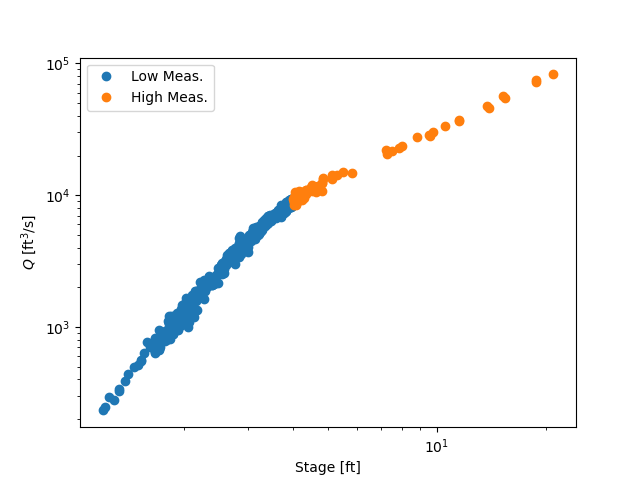

In [19]:
h_break = 4.

meas_low = meas.loc[(meas['gage_height_va'] < h_break)]
meas_high = meas.loc[(meas['gage_height_va'] >= h_break)]

h_low = np.array(meas_low.gage_height_va)
Q_low = np.array(meas_low.discharge_va)

h_high = np.array(meas_high.gage_height_va)
Q_high = np.array(meas_high.discharge_va)

# now visualize

fig, ax = plt.subplots()
ax.plot(h_low, Q_low,'o',alpha=1, label='Low Meas.')
ax.plot(h_high, Q_high,'o',alpha=1, label='High Meas.')
# ax.plot(hcalc, powerlaw(hcalc,*popt),'--k',alpha=1, label='Fit model')
ax.set_ylabel('$Q~\mathrm{[ft^3/s]}$')
ax.set_xlabel('Stage [ft]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend();

Let's do the fit in parts. We'll try both types of power laws

### full power law $ Q = \gamma + \alpha h^\beta $

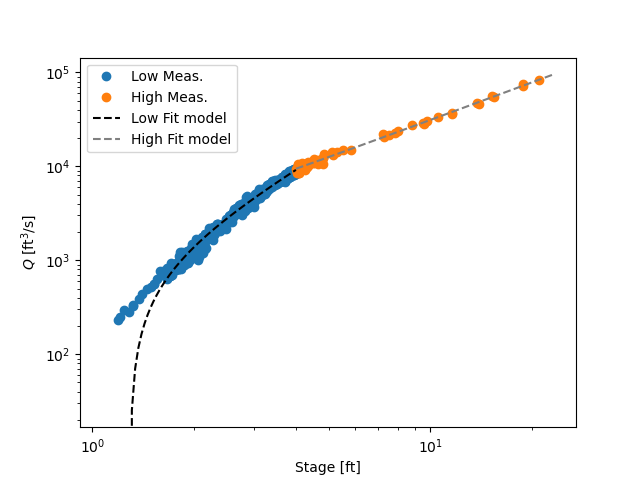

In [20]:
poptL, pcovL = curve_fit(powerlaw, h_low, Q_low)
poptH, pcovH = curve_fit(powerlaw, h_high, Q_high)

hcalc_low = np.linspace(min(h)-0.1*min(h),h_break,100)
hcalc_high = np.linspace(h_break,max(h)+0.1*max(h),100)

fig, ax = plt.subplots()
ax.plot(h_low, Q_low,'o',alpha=1, label='Low Meas.')
ax.plot(h_high, Q_high,'o',alpha=1, label='High Meas.')

ax.plot(hcalc_low, powerlaw(hcalc_low,*poptL),'--',color='black',alpha=1, label='Low Fit model')
ax.plot(hcalc_high, powerlaw(hcalc_high,*poptH),'--',color='gray',alpha=1, label='High Fit model')

ax.set_ylabel('$Q~\mathrm{[ft^3/s]}$')
ax.set_xlabel('Stage [ft]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend();

### Pure power law $ Q =  \alpha h^\beta $

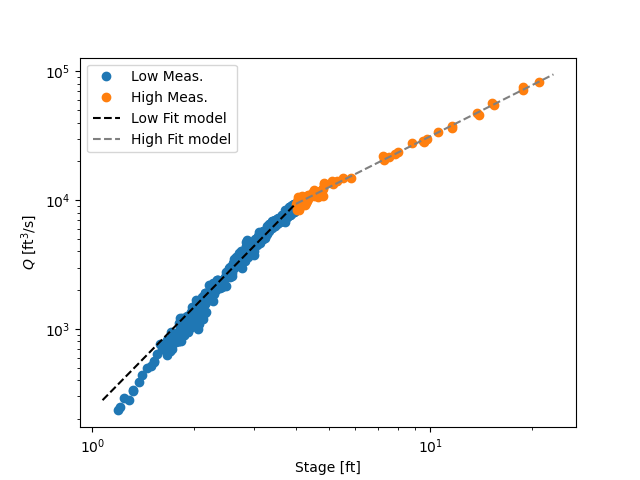

In [21]:
poptLp, pcovL = curve_fit(powerlawpure, h_low, Q_low)
poptHp, pcovH = curve_fit(powerlawpure, h_high, Q_high)

hcalc_low = np.linspace(min(h)-0.1*min(h),h_break,100)
hcalc_high = np.linspace(h_break,max(h)+0.1*max(h),100)

fig, ax = plt.subplots()
ax.plot(h_low, Q_low,'o',alpha=1, label='Low Meas.')
ax.plot(h_high, Q_high,'o',alpha=1, label='High Meas.')

ax.plot(hcalc_low, powerlawpure(hcalc_low,*poptLp),'--',color='black',alpha=1, label='Low Fit model')
ax.plot(hcalc_high, powerlawpure(hcalc_high,*poptHp),'--',color='gray',alpha=1, label='High Fit model')

ax.set_ylabel('$Q~\mathrm{[ft^3/s]}$')
ax.set_xlabel('Stage [ft]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend();

Which do you think we should use and why? Once you answer, set the model coefficents to the model of your choice.

In [22]:
coefL = poptLp
coefH = poptHp

## Predict discharge with your model

Load in the 15 min USGS data

In [23]:
datafile = 'NewRiver_1year_15minQ_stage.csv'
Q15 = pd.read_csv(datafile)
Q15

,agency_cd,site_no,datetime,tz_cd,Q_cfs,147680_00060_cd,stage_ft,147681_00065_cd
0,USGS,3171000,2021-06-24 0:00,EDT,3380,A,2.81,A
1,USGS,3171000,2021-06-24 0:15,EDT,3230,A,2.77,A
2,USGS,3171000,2021-06-24 0:30,EDT,3120,A,2.74,A
3,USGS,3171000,2021-06-24 0:45,EDT,2980,A,2.70,A
4,USGS,3171000,2021-06-24 1:00,EDT,2830,A,2.66,A
...,...,...,...,...,...,...,...,...
35081,USGS,3171000,2022-06-24 11:15,EDT,1880,P,2.39,P
35082,USGS,3171000,2022-06-24 11:30,EDT,1850,P,2.38,P
35083,USGS,3171000,2022-06-24 11:45,EDT,1820,P,2.37,P
35084,USGS,3171000,2022-06-24 12:00,EDT,1820,P,2.37,P


Break the measured data into a low and high stage set

In [24]:
low_stage = Q15.loc[(Q15['stage_ft'] < h_break)]
high_stage = Q15.loc[(Q15['stage_ft'] >= h_break)]

No predict the discharge given the measured stage and model

In [25]:
QpL = powerlawpure(low_stage.stage_ft,*coefL)
QpH = powerlawpure(high_stage.stage_ft,*coefH)

Plot the measured, or reported $Q$ data, from the USGS website against the $Q$ predicted by the model and the measured stage. If the prediction is perfect, it will fall on a one-to-one line running diagonally through the plot.

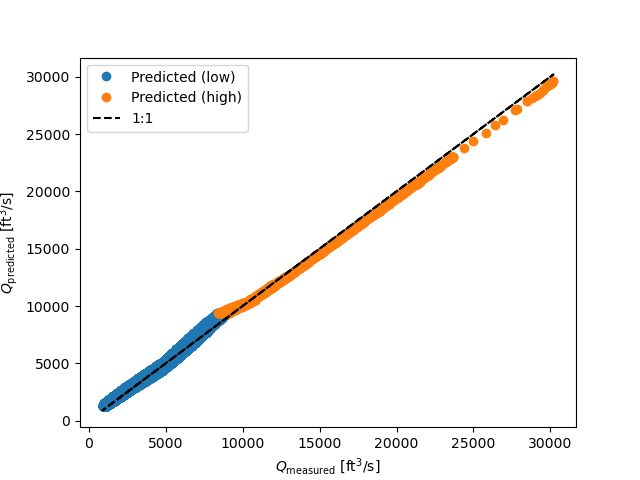

In [26]:
fig, ax = plt.subplots()
ax.plot(low_stage.Q_cfs, QpL,'o',alpha=1, label='Predicted (low)')
ax.plot(high_stage.Q_cfs, QpH,'o',alpha=1, label='Predicted (high)')
ax.plot(Q15.Q_cfs, Q15.Q_cfs,'--k',alpha=1, label='1:1')
ax.set_ylabel('$Q_{\mathrm{predicted}}~\mathrm{[ft^3/s]}$')
ax.set_xlabel('$Q_{\mathrm{measured}}~\mathrm{[ft^3/s]}$')
ax.legend();